<a href="https://colab.research.google.com/github/ShriShalini/Time-Series-Forecasting/blob/main/n_beats_exreme_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
! pip install darts

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
series_ai = pd.read_csv('/content/ai_count_no_ouliers.csv')


In [28]:
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
scaler_ai_retweet = Scaler()

series_ai_count = scaler_ai_retweet.fit_transform(
        TimeSeries.from_dataframe(
            series_ai, 'date', ['count'])
    ) 
#series_ai_count.plot(label ='count')
#plt.xlabel('date')
#plt.ylabel('tweet_count')
#fig1 = plt.gcf()
#plt.legend();
#plt.show()
#fig1.savefig('tweet_count.png')

In [29]:
train_tweet_count, val_tweet_count = series_ai_count.split_after(pd.Timestamp('20200930'))

In [30]:
import torch

In [31]:
def extreme_true(pred,true):
  #define the hi_th anf lw_th
  hi_th = 0.65
  lw_th = 0.2
  if (pred>hi_th or pred <lw_th)  and (true <= hi_th and true >=lw_th):
    return True
  elif (true>hi_th or true <lw_th)  and (pred <= hi_th and pred >=lw_th):
    return True
  else:
    return False  
    


In [32]:
def extreme_tensor(pred_tensor,true_tensor):
  hi_th = 0.65
  lw_th = 0.2
  high_tensor = torch.full((pred_tensor.size[0],pred_tensor.size[1],pred_tensor.size[2]), hi_th)
  lw_tensor = torch.full((pred_tensor.size[0],pred_tensor.size[1],pred_tensor.size[2]), hi_th)
  #compare the pred with the high and low_tensor
  pred_comp_hi = torch.tensor.gt(pred_tensor,high_tensor)
  pred_comp_lw = torch.tensor.le(pred_tensor,lw_tensor)
  
  # an or to know if it is extreme or not  
  extreme_pred = torch.logical_or(pred_comp_hi,pred_comp_lw)
  #compare the true with the high and low
  true_comp_hi = torch.tensor.gt(true_tensor,high_tensor)
  true_comp_lw = torch.tensor.le(true_tensor,lw_tensor)
  
  # an and to know if it is extreme or not
  extreme_true = torch.logical_and(true_comp_hi,true_comp_lw)
  #get the and of the 2 above
  
  extreme_final = torch.logical_and(extreme_pred,extreme_true)

  #get the diff from the pred and true



  # change the values of the true and false to the hyperparamters of the loss



  # do multiplication of the 2 above 




In [22]:
 def ExtremeLoss(preds, true):
   # define the upper and the lower thresholds
  loss = list(range(0,preds.shape[0]))
   # 1st loop for the batch
  batch_counter =0  
  for pred in preds:
    
     #pred is a tensor of 7 dimsneions 
     #2nd loop for dims in the tensor
     dim_counter = -1 
     for dim in pred :
       dim_counter +=1
       if extreme_true(dim,true[batch_counter][dim_counter] ) == True:
        # extreme loss
          loss[batch_counter] += (dim - true[batch_counter][dim_counter])*100
       else:
        #simple loss
          loss[batch_counter] += (dim - true[batch_counter][dim_counter])/16 

     batch_counter +=1
  loss_tensor = torch.tensor(loss, requires_grad= True)
  print(torch.sum(loss_tensor)) 
  return torch.sum(loss_tensor)

In [33]:
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

In [36]:
model_ai = NBEATSModel(input_chunk_length=60, output_chunk_length=7, n_epochs=300, random_state=0,
                                          loss_fn = ExtremeLoss )
model_ai.fit([train_tweet_count],val_series = [val_tweet_count], verbose=True)
pred_ai = model_ai.predict(n=88, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:88],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )

[2021-11-30 08:06:46,317] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-11-30 08:06:46,317] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-11-30 08:06:46,407] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-30 08:06:46,407] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  0%|          | 0/300 [00:00<?, ?it/s]

tensor(1307.5483, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1429.9292, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(688.0376, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(957.8827, dtype=torch.float64, grad_fn=<SumBackward0>)


  0%|          | 1/300 [00:00<02:01,  2.45it/s]

tensor(-132.8799, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1029.3189, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(233.7365, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(304.8778, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(404.7844, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1349.2053, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-244.1518, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-388.5756, dtype=torch.float64, grad_fn=<SumBackward0>)


  1%|          | 2/300 [00:00<01:53,  2.62it/s]

tensor(1450.1211, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(578.6743, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(685.1311, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1233.5357, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1003.5824, dtype=torch.float64, grad_fn=<SumBackward0>)


  1%|          | 3/300 [00:01<01:49,  2.71it/s]

tensor(201.5247, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-145.4531, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-16.9091, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(493.5239, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(349.9478, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1259.9970, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(713.8733, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-114.6153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1184.2920, dtype=torch.float64, grad_fn=<SumBackward0>)


  1%|▏         | 4/300 [00:01<01:48,  2.72it/s]

tensor(400.2272, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-338.7865, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(956.1789, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1019.8088, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1307.8545, dtype=torch.float64, grad_fn=<SumBackward0>)


  2%|▏         | 5/300 [00:01<01:47,  2.73it/s]

tensor(1712.3207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-95.6264, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(787.4212, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(382.6868, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(10.0025, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1857.8992, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-126.9686, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-433.4493, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(211.2653, dtype=torch.float64, grad_fn=<SumBackward0>)


  2%|▏         | 6/300 [00:02<01:46,  2.76it/s]

tensor(2142.7068, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-206.5204, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1334.4104, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(123.1233, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(977.1031, dtype=torch.float64, grad_fn=<SumBackward0>)


  2%|▏         | 7/300 [00:02<01:46,  2.76it/s]

tensor(1697.9434, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(788.9462, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1658.4099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(191.8189, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(148.0625, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-534.1943, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.0664, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1936.1278, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-397.1356, dtype=torch.float64, grad_fn=<SumBackward0>)


  3%|▎         | 8/300 [00:02<01:44,  2.79it/s]

tensor(1732.0335, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(564.9752, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1034.3805, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1245.7530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-98.8735, dtype=torch.float64, grad_fn=<SumBackward0>)


  3%|▎         | 9/300 [00:03<01:44,  2.79it/s]

tensor(194.0289, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-908.9180, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1490.3008, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(498.2638, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1029.5620, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(672.3939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-183.3149, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-430.6603, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(504.2576, dtype=torch.float64, grad_fn=<SumBackward0>)


  3%|▎         | 10/300 [00:03<01:43,  2.81it/s]

tensor(2132.6416, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-269.9444, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1330.9671, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(410.7778, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(114.2377, dtype=torch.float64, grad_fn=<SumBackward0>)


  4%|▎         | 11/300 [00:04<01:45,  2.74it/s]

tensor(1280.8380, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1839.4480, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1633.1160, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(111.7829, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1402.1100, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-243.1711, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2234.1971, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(442.1637, dtype=torch.float64, grad_fn=<SumBackward0>)


  4%|▍         | 12/300 [00:04<01:44,  2.75it/s]

tensor(372.3263, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-804.2199, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(51.5294, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(739.1973, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(17.5121, dtype=torch.float64, grad_fn=<SumBackward0>)


  4%|▍         | 13/300 [00:04<01:42,  2.80it/s]

tensor(1481.9153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(351.0549, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-103.4779, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1893.5540, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-924.8202, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1266.9385, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(224.6598, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1306.7696, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-774.8447, dtype=torch.float64, grad_fn=<SumBackward0>)


  5%|▍         | 14/300 [00:05<01:41,  2.80it/s]

tensor(879.9395, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(107.3375, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(444.1354, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(474.0976, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(130.7321, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(909.4952, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1071.5623, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1115.3842, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1527.5202, dtype=torch.float64, grad_fn=<SumBackward0>)


  5%|▌         | 15/300 [00:05<01:42,  2.77it/s]

tensor(456.9123, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(499.4137, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2446.4240, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2154.0285, dtype=torch.float64, grad_fn=<SumBackward0>)


  5%|▌         | 16/300 [00:05<01:43,  2.74it/s]

tensor(-407.1127, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-913.1556, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(365.5575, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-690.2199, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(554.9267, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-146.2524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(139.7023, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(481.8360, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1324.4290, dtype=torch.float64, grad_fn=<SumBackward0>)


  6%|▌         | 17/300 [00:06<01:43,  2.74it/s]

tensor(362.2598, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(738.0340, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-108.8028, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1293.3128, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2194.4802, dtype=torch.float64, grad_fn=<SumBackward0>)


  6%|▌         | 18/300 [00:06<01:41,  2.77it/s]

tensor(-786.6904, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(454.6976, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-706.3230, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1114.2610, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2094.4679, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-381.6450, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(295.1576, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(77.8171, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(584.1994, dtype=torch.float64, grad_fn=<SumBackward0>)


  6%|▋         | 19/300 [00:06<01:41,  2.76it/s]

tensor(1688.3890, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-903.4505, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(374.0812, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(337.2186, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(652.5808, dtype=torch.float64, grad_fn=<SumBackward0>)


  7%|▋         | 20/300 [00:07<01:40,  2.78it/s]

tensor(-603.4370, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1491.3522, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1283.0026, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-79.8629, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2701.6038, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-66.2906, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(321.7099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(28.9932, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(492.7645, dtype=torch.float64, grad_fn=<SumBackward0>)


  7%|▋         | 21/300 [00:07<01:43,  2.69it/s]

tensor(-280.8327, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(256.9874, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1286.7273, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(719.8119, dtype=torch.float64, grad_fn=<SumBackward0>)


  7%|▋         | 22/300 [00:08<01:41,  2.74it/s]

tensor(483.1666, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-205.6734, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(368.7475, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(934.7994, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-132.6439, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1322.6987, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-342.0998, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-605.7663, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1274.0771, dtype=torch.float64, grad_fn=<SumBackward0>)


  8%|▊         | 23/300 [00:08<01:42,  2.71it/s]

tensor(371.6942, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1648.1127, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-213.7811, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(952.1063, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-808.3262, dtype=torch.float64, grad_fn=<SumBackward0>)


  8%|▊         | 24/300 [00:08<01:40,  2.75it/s]

tensor(-19.3899, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(538.7934, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2162.8812, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(594.6284, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(34.2423, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2384.7198, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1687.5763, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(67.7369, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(181.4745, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-319.2909, dtype=torch.float64, grad_fn=<SumBackward0>)


  8%|▊         | 25/300 [00:09<01:39,  2.76it/s]

tensor(-1328.2764, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(780.9953, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(805.7198, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(153.4794, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-78.6556, dtype=torch.float64, grad_fn=<SumBackward0>)


  9%|▊         | 26/300 [00:09<01:38,  2.77it/s]

tensor(-60.5374, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2103.7328, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-183.8832, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(715.0796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(378.7805, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1037.1479, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1351.2910, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1245.2192, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-741.8987, dtype=torch.float64, grad_fn=<SumBackward0>)


  9%|▉         | 27/300 [00:09<01:38,  2.78it/s]

tensor(588.3679, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-403.9723, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1222.2098, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1445.6347, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-597.2623, dtype=torch.float64, grad_fn=<SumBackward0>)


  9%|▉         | 28/300 [00:10<01:37,  2.78it/s]

tensor(-264.1230, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(42.4834, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(965.7478, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(640.2450, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1680.4444, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(867.8338, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1450.3003, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(825.0999, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1081.6024, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-742.3249, dtype=torch.float64, grad_fn=<SumBackward0>)


 10%|▉         | 29/300 [00:10<01:37,  2.79it/s]

tensor(455.1843, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-921.9247, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-141.2341, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(414.5773, dtype=torch.float64, grad_fn=<SumBackward0>)


 10%|█         | 30/300 [00:10<01:37,  2.78it/s]

tensor(1027.3441, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(720.3125, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1836.2560, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(519.6044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(985.9110, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(72.7837, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(120.5756, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1074.3474, dtype=torch.float64, grad_fn=<SumBackward0>)


 10%|█         | 31/300 [00:11<01:40,  2.66it/s]

tensor(996.3114, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(109.3993, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(95.6069, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1424.1807, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(506.2127, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(902.0191, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(13.1390, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(524.1346, dtype=torch.float64, grad_fn=<SumBackward0>)


 11%|█         | 32/300 [00:11<01:39,  2.69it/s]

tensor(132.4874, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-47.2379, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(479.3205, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(445.2499, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1472.0648, dtype=torch.float64, grad_fn=<SumBackward0>)


 11%|█         | 33/300 [00:12<01:37,  2.75it/s]

tensor(643.0245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(705.6877, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(436.0203, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-726.4322, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(607.9616, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(718.7917, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1828.6537, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1111.2103, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-39.7752, dtype=torch.float64, grad_fn=<SumBackward0>)


 11%|█▏        | 34/300 [00:12<01:37,  2.73it/s]

tensor(-613.9015, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-158.0052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1668.4147, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-664.4871, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-45.8836, dtype=torch.float64, grad_fn=<SumBackward0>)


 12%|█▏        | 35/300 [00:12<01:35,  2.77it/s]

tensor(1002.0982, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1177.6555, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(9.7640, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(307.3737, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-444.4584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(759.2865, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(710.2343, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1813.5766, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-863.0055, dtype=torch.float64, grad_fn=<SumBackward0>)


 12%|█▏        | 36/300 [00:13<01:34,  2.79it/s]

tensor(1551.0703, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-71.7683, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(793.8124, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-398.6245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-131.8506, dtype=torch.float64, grad_fn=<SumBackward0>)


 12%|█▏        | 37/300 [00:13<01:35,  2.75it/s]

tensor(739.7049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1379.6871, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1129.4288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-57.2226, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-623.8959, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-744.7993, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(806.2217, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-593.6779, dtype=torch.float64, grad_fn=<SumBackward0>)


 13%|█▎        | 38/300 [00:13<01:34,  2.76it/s]

tensor(2757.3523, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1368.9822, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(484.7524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1122.0600, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1822.3210, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(115.6007, dtype=torch.float64, grad_fn=<SumBackward0>)


 13%|█▎        | 39/300 [00:14<01:33,  2.80it/s]

tensor(-680.7934, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1510.3236, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-521.7504, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(87.1740, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-342.1392, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1149.5379, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(7.4139, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(299.0887, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(174.7168, dtype=torch.float64, grad_fn=<SumBackward0>)


 13%|█▎        | 40/300 [00:14<01:33,  2.79it/s]

tensor(2054.8214, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(111.4961, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(63.5060, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1874.5728, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(134.0934, dtype=torch.float64, grad_fn=<SumBackward0>)


 14%|█▎        | 41/300 [00:14<01:35,  2.71it/s]

tensor(866.7800, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(803.6001, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(195.4532, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-483.0700, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1285.9894, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1280.8675, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1592.3208, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1023.1661, dtype=torch.float64, grad_fn=<SumBackward0>)


 14%|█▍        | 42/300 [00:15<01:34,  2.72it/s]

tensor(-379.5221, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(78.5737, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(619.8724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1386.3192, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(713.5083, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(606.0009, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1174.2044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1825.0569, dtype=torch.float64, grad_fn=<SumBackward0>)


 14%|█▍        | 43/300 [00:15<01:34,  2.72it/s]

tensor(197.7608, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-99.5062, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1199.7890, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1423.7757, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(958.3851, dtype=torch.float64, grad_fn=<SumBackward0>)


 15%|█▍        | 44/300 [00:15<01:32,  2.76it/s]

tensor(392.1887, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-495.5711, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-372.9587, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(349.3267, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(334.6812, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(601.1736, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-544.3213, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(696.9853, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1113.6386, dtype=torch.float64, grad_fn=<SumBackward0>)


 15%|█▌        | 45/300 [00:16<01:31,  2.78it/s]

tensor(162.3230, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1090.4551, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(238.0525, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-867.9445, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2300.4247, dtype=torch.float64, grad_fn=<SumBackward0>)


 15%|█▌        | 46/300 [00:16<01:30,  2.79it/s]

tensor(2326.9533, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-966.6091, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(585.3908, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-161.3322, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1260.9609, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-354.5604, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1071.3985, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(703.9680, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(598.3679, dtype=torch.float64, grad_fn=<SumBackward0>)


 16%|█▌        | 47/300 [00:17<01:31,  2.78it/s]

tensor(-44.2392, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(219.0398, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(429.2365, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2082.2739, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-230.1730, dtype=torch.float64, grad_fn=<SumBackward0>)


 16%|█▌        | 48/300 [00:17<01:30,  2.80it/s]

tensor(-382.7877, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(758.4673, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(797.8153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.1031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-105.6771, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1288.4835, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-6.4014, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(450.1550, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(942.3279, dtype=torch.float64, grad_fn=<SumBackward0>)


 16%|█▋        | 49/300 [00:17<01:29,  2.81it/s]

tensor(856.9513, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(29.0963, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(523.8025, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(215.6474, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(976.1874, dtype=torch.float64, grad_fn=<SumBackward0>)


 17%|█▋        | 50/300 [00:18<01:28,  2.81it/s]

tensor(1397.7073, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-333.1781, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(189.1796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(485.5895, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2636.6216, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(277.9732, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(405.9027, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(708.3096, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(716.4411, dtype=torch.float64, grad_fn=<SumBackward0>)


 17%|█▋        | 51/300 [00:18<01:31,  2.72it/s]

tensor(-793.8367, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-496.4760, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1439.9836, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(810.5969, dtype=torch.float64, grad_fn=<SumBackward0>)


 17%|█▋        | 52/300 [00:18<01:30,  2.75it/s]

tensor(469.1524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-97.0731, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(562.6590, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(372.8897, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-103.2732, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1085.3883, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(332.5639, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1579.5908, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-169.1627, dtype=torch.float64, grad_fn=<SumBackward0>)


 18%|█▊        | 53/300 [00:19<01:28,  2.78it/s]

tensor(-1351.2831, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1676.6730, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(301.1653, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-852.8289, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1156.8945, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(335.2843, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(89.4342, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1525.7887, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(837.8307, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(362.5321, dtype=torch.float64, grad_fn=<SumBackward0>)


 18%|█▊        | 54/300 [00:19<01:29,  2.75it/s]

tensor(463.7702, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(334.0899, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-152.9241, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1551.4475, dtype=torch.float64, grad_fn=<SumBackward0>)


 18%|█▊        | 55/300 [00:19<01:28,  2.76it/s]

tensor(686.5405, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-472.2811, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1044.2926, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1999.0968, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-988.4149, dtype=torch.float64, grad_fn=<SumBackward0>)


 19%|█▊        | 56/300 [00:20<01:27,  2.79it/s]

tensor(656.8757, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(363.2697, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(280.7321, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1030.2393, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(113.1368, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1046.2514, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(542.3132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1120.7402, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1000.0925, dtype=torch.float64, grad_fn=<SumBackward0>)


 19%|█▉        | 57/300 [00:20<01:27,  2.79it/s]

tensor(-677.9548, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-7.9402, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(431.4331, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(394.7049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-47.9244, dtype=torch.float64, grad_fn=<SumBackward0>)


 19%|█▉        | 58/300 [00:21<01:26,  2.81it/s]

tensor(1062.1795, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1085.2455, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-421.4180, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(581.2148, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(800.9331, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.8232, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1277.3351, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(70.5764, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1447.9393, dtype=torch.float64, grad_fn=<SumBackward0>)


 20%|█▉        | 59/300 [00:21<01:27,  2.75it/s]

tensor(412.8699, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(400.9796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-160.5881, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1289.5490, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2485.6523, dtype=torch.float64, grad_fn=<SumBackward0>)


 20%|██        | 60/300 [00:21<01:26,  2.78it/s]

tensor(-433.9386, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-26.7169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(182.9433, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(147.3751, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-189.9288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-346.9826, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1200.6564, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(875.6505, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(616.7496, dtype=torch.float64, grad_fn=<SumBackward0>)


 20%|██        | 61/300 [00:22<01:29,  2.68it/s]

tensor(943.4882, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(307.2134, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-141.8401, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-202.2449, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1028.2815, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1155.4385, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1782.6936, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-882.4448, dtype=torch.float64, grad_fn=<SumBackward0>)


 21%|██        | 62/300 [00:22<01:30,  2.62it/s]

tensor(1005.5664, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-432.3548, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(447.1432, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-39.4124, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(994.0579, dtype=torch.float64, grad_fn=<SumBackward0>)


 21%|██        | 63/300 [00:22<01:28,  2.68it/s]

tensor(977.9614, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(598.3146, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(618.0614, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-141.1907, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-703.3045, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1114.8682, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-408.4809, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-147.3195, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2506.0703, dtype=torch.float64, grad_fn=<SumBackward0>)


 21%|██▏       | 64/300 [00:23<01:28,  2.66it/s]

tensor(-26.1475, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1119.2495, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(832.9084, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1131.1731, dtype=torch.float64, grad_fn=<SumBackward0>)


 22%|██▏       | 65/300 [00:23<01:28,  2.66it/s]

tensor(-399.2264, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1603.5972, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-62.4132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(58.7351, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(290.1613, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1188.8292, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(757.2470, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-70.3769, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-12.3866, dtype=torch.float64, grad_fn=<SumBackward0>)


 22%|██▏       | 66/300 [00:24<01:26,  2.70it/s]

tensor(992.3854, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(841.3476, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-242.1102, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1348.0423, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-136.7055, dtype=torch.float64, grad_fn=<SumBackward0>)


 22%|██▏       | 67/300 [00:24<01:25,  2.73it/s]

tensor(1510.6922, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(367.2079, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1975.7414, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1462.4232, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-147.6196, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(381.5151, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-554.4200, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(556.8477, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(400.3132, dtype=torch.float64, grad_fn=<SumBackward0>)


 23%|██▎       | 68/300 [00:24<01:25,  2.72it/s]

tensor(-390.7840, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1912.3124, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1149.1510, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-173.0968, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(727.2967, dtype=torch.float64, grad_fn=<SumBackward0>)


 23%|██▎       | 69/300 [00:25<01:24,  2.75it/s]

tensor(-13.3770, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(57.5670, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-409.2377, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2211.6416, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1054.1417, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(931.3971, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(193.1472, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(150.8168, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-139.9161, dtype=torch.float64, grad_fn=<SumBackward0>)


 23%|██▎       | 70/300 [00:25<01:23,  2.75it/s]

tensor(708.3650, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1457.0604, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(154.0652, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(219.8724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(224.8190, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-295.5818, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1502.8228, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1544.6423, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(210.3052, dtype=torch.float64, grad_fn=<SumBackward0>)


 24%|██▎       | 71/300 [00:25<01:26,  2.66it/s]

tensor(48.0555, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(315.7495, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(191.6767, dtype=torch.float64, grad_fn=<SumBackward0>)


 24%|██▍       | 72/300 [00:26<01:23,  2.72it/s]

tensor(1712.9317, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(196.3113, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(563.6040, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(412.8799, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(61.7824, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(297.8465, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(941.1680, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(500.7290, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1686.2934, dtype=torch.float64, grad_fn=<SumBackward0>)


 24%|██▍       | 73/300 [00:26<01:24,  2.70it/s]

tensor(-1155.5142, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(310.4599, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(873.9529, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1496.8159, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-266.0887, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1031.9504, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1348.0928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-773.2649, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(622.2825, dtype=torch.float64, grad_fn=<SumBackward0>)


 25%|██▍       | 74/300 [00:27<01:25,  2.64it/s]

tensor(-4.8525, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-262.4593, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1400.1597, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(41.0080, dtype=torch.float64, grad_fn=<SumBackward0>)


 25%|██▌       | 75/300 [00:27<01:23,  2.71it/s]

tensor(64.6722, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-453.0663, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1475.8072, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1188.8140, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-613.0310, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(957.8490, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1532.7210, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(790.5472, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(807.1573, dtype=torch.float64, grad_fn=<SumBackward0>)


 25%|██▌       | 76/300 [00:27<01:22,  2.72it/s]

tensor(-109.0093, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(88.7013, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(862.3055, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(816.9618, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1016.9302, dtype=torch.float64, grad_fn=<SumBackward0>)


 26%|██▌       | 77/300 [00:28<01:20,  2.76it/s]

tensor(1513.8822, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-561.9090, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-656.0007, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(462.7655, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(440.7078, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(148.2658, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1173.7619, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-321.5987, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(534.0234, dtype=torch.float64, grad_fn=<SumBackward0>)


 26%|██▌       | 78/300 [00:28<01:20,  2.77it/s]

tensor(1904.6745, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-424.8992, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1046.7050, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-133.2441, dtype=torch.float64, grad_fn=<SumBackward0>)


 26%|██▋       | 79/300 [00:28<01:20,  2.74it/s]

tensor(-248.5922, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1269.8675, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(410.7464, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1199.3801, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-89.9272, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(41.0361, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(708.6197, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1154.3440, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(804.8359, dtype=torch.float64, grad_fn=<SumBackward0>)


 27%|██▋       | 80/300 [00:29<01:19,  2.76it/s]

tensor(850.2948, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(525.3733, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-629.5682, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1575.2116, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(195.2201, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-57.0313, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(902.0748, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-16.5339, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(598.5764, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(257.4179, dtype=torch.float64, grad_fn=<SumBackward0>)


 27%|██▋       | 81/300 [00:29<01:21,  2.67it/s]

tensor(1291.2142, dtype=torch.float64)
tensor(571.0558, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1108.2176, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-631.5963, dtype=torch.float64, grad_fn=<SumBackward0>)


 27%|██▋       | 82/300 [00:29<01:20,  2.70it/s]

tensor(529.9966, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(283.9380, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1108.3299, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(484.9938, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(530.0019, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(246.3142, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(854.5957, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(423.0477, dtype=torch.float64, grad_fn=<SumBackward0>)


 28%|██▊       | 83/300 [00:30<01:20,  2.70it/s]

tensor(-195.2938, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1273.9100, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(322.3598, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(490.1168, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1745.5624, dtype=torch.float64, grad_fn=<SumBackward0>)


 28%|██▊       | 84/300 [00:30<01:18,  2.73it/s]

tensor(1285.8244, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-180.4928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-393.7163, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(275.1688, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(232.4722, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1135.4152, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-2017.2964, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(7.8538, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(338.2153, dtype=torch.float64, grad_fn=<SumBackward0>)


 28%|██▊       | 85/300 [00:30<01:17,  2.77it/s]

tensor(911.0931, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(3157.2796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-77.6252, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-594.8071, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(717.0982, dtype=torch.float64, grad_fn=<SumBackward0>)


 29%|██▊       | 86/300 [00:31<01:16,  2.79it/s]

tensor(993.8542, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(475.8018, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1657.1952, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-179.3556, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(385.1487, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(747.3007, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-733.7219, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-53.6933, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1060.6714, dtype=torch.float64, grad_fn=<SumBackward0>)


 29%|██▉       | 87/300 [00:31<01:19,  2.67it/s]

tensor(837.0700, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(705.4032, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(891.9053, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(170.3397, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(500.2717, dtype=torch.float64, grad_fn=<SumBackward0>)


 29%|██▉       | 88/300 [00:32<01:17,  2.73it/s]

tensor(723.1530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-293.2693, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(566.0155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(704.5839, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1083.8410, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-67.8155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(54.9455, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(491.9832, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1375.8602, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1420.7318, dtype=torch.float64, grad_fn=<SumBackward0>)


 30%|██▉       | 89/300 [00:32<01:16,  2.75it/s]

tensor(399.2922, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-220.0619, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-35.1085, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2665.4509, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(197.6022, dtype=torch.float64, grad_fn=<SumBackward0>)


 30%|███       | 90/300 [00:32<01:16,  2.76it/s]

tensor(180.6268, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(616.7101, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(133.6446, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-303.9905, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(825.8317, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(837.1750, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2284.7584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-678.4461, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1512.4718, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1260.6135, dtype=torch.float64, grad_fn=<SumBackward0>)


 30%|███       | 91/300 [00:33<01:18,  2.68it/s]

tensor(-66.2418, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1436.5349, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(456.9219, dtype=torch.float64, grad_fn=<SumBackward0>)


 31%|███       | 92/300 [00:33<01:16,  2.72it/s]

tensor(-55.5932, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(962.6152, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-456.8003, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1029.8525, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(81.4044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1423.2667, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(308.2634, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(879.6450, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(757.9074, dtype=torch.float64, grad_fn=<SumBackward0>)


 31%|███       | 93/300 [00:33<01:16,  2.69it/s]

tensor(482.9542, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-462.8820, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(65.7808, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-230.3434, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1643.6019, dtype=torch.float64, grad_fn=<SumBackward0>)


 31%|███▏      | 94/300 [00:34<01:15,  2.72it/s]

tensor(-420.8489, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(208.9453, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(872.1361, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2146.1818, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-764.7373, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(754.2641, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-0.7524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(698.9383, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-436.0986, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(974.4467, dtype=torch.float64, grad_fn=<SumBackward0>)


 32%|███▏      | 95/300 [00:34<01:14,  2.74it/s]

tensor(1168.3427, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(295.7946, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-222.2753, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1305.8787, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(588.7212, dtype=torch.float64, grad_fn=<SumBackward0>)


 32%|███▏      | 96/300 [00:35<01:13,  2.76it/s]

tensor(63.0956, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1332.5939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(603.3411, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-216.4197, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2528.0596, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-918.7293, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(745.0885, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(710.3269, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-135.8230, dtype=torch.float64, grad_fn=<SumBackward0>)


 32%|███▏      | 97/300 [00:35<01:13,  2.75it/s]

tensor(1163.7096, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-637.6968, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1301.6197, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(312.6153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(259.1251, dtype=torch.float64, grad_fn=<SumBackward0>)


 33%|███▎      | 98/300 [00:35<01:13,  2.76it/s]

tensor(1218.8224, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(520.3029, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-200.3813, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(42.8314, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-69.9816, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2243.2801, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-867.3470, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(305.7914, dtype=torch.float64, grad_fn=<SumBackward0>)


 33%|███▎      | 99/300 [00:36<01:14,  2.70it/s]

tensor(918.2241, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1136.1828, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-211.2143, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-448.1696, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-467.3660, dtype=torch.float64, grad_fn=<SumBackward0>)


 33%|███▎      | 100/300 [00:36<01:13,  2.72it/s]

tensor(291.5065, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2267.7611, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1162.5849, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(537.2603, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(111.3584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-706.5248, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(250.6581, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(70.8356, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(327.5500, dtype=torch.float64, grad_fn=<SumBackward0>)


 34%|███▎      | 101/300 [00:36<01:15,  2.63it/s]

tensor(517.0618, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2525.2274, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(470.1275, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(11.8070, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1005.4086, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(375.5447, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1412.0966, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(702.3959, dtype=torch.float64, grad_fn=<SumBackward0>)


 34%|███▍      | 102/300 [00:37<01:15,  2.64it/s]

tensor(453.7570, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-506.0744, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(778.8136, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1478.1664, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(632.5158, dtype=torch.float64, grad_fn=<SumBackward0>)


 34%|███▍      | 103/300 [00:37<01:12,  2.71it/s]

tensor(-473.3642, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(869.2363, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-242.0858, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(411.6535, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1118.2209, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1468.1853, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(613.6589, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(212.4056, dtype=torch.float64, grad_fn=<SumBackward0>)


 35%|███▍      | 104/300 [00:38<01:12,  2.71it/s]

tensor(194.5306, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(621.2049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-773.2707, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(230.6145, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1365.2286, dtype=torch.float64, grad_fn=<SumBackward0>)


 35%|███▌      | 105/300 [00:38<01:11,  2.73it/s]

tensor(586.2597, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(27.4414, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(701.7494, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(501.1200, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(42.5218, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(537.7527, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-619.5776, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(444.9363, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1678.1806, dtype=torch.float64, grad_fn=<SumBackward0>)


 35%|███▌      | 106/300 [00:38<01:10,  2.75it/s]

tensor(190.0478, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(685.4620, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(538.1337, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-234.7892, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-10.5990, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(876.5233, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1455.0456, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(258.4210, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1230.7980, dtype=torch.float64, grad_fn=<SumBackward0>)


 36%|███▌      | 107/300 [00:39<01:12,  2.68it/s]

tensor(-120.4642, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1041.7420, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(484.6844, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(725.8169, dtype=torch.float64, grad_fn=<SumBackward0>)


 36%|███▌      | 108/300 [00:39<01:10,  2.74it/s]

tensor(-361.6191, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1548.1891, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-47.9701, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(64.0922, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-287.5112, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(388.5694, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1106.0791, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-509.2476, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1541.7089, dtype=torch.float64, grad_fn=<SumBackward0>)


 36%|███▋      | 109/300 [00:39<01:09,  2.75it/s]

tensor(60.8999, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1154.4370, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-220.2786, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2054.7103, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-929.1458, dtype=torch.float64, grad_fn=<SumBackward0>)


 37%|███▋      | 110/300 [00:40<01:08,  2.77it/s]

tensor(717.7813, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(903.6910, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(912.9538, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(15.2236, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1937.2493, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-645.1811, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(403.2673, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1764.2616, dtype=torch.float64, grad_fn=<SumBackward0>)


 37%|███▋      | 111/300 [00:40<01:11,  2.66it/s]

tensor(165.6493, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-434.4588, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(264.1479, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(375.1093, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(192.7750, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1529.7539, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(224.6998, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1628.3213, dtype=torch.float64, grad_fn=<SumBackward0>)


 37%|███▋      | 112/300 [00:40<01:11,  2.62it/s]

tensor(471.9739, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-967.6977, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(941.4431, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-35.8503, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1230.7859, dtype=torch.float64, grad_fn=<SumBackward0>)


 38%|███▊      | 113/300 [00:41<01:10,  2.67it/s]

tensor(525.9207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-498.0073, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1076.4791, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(214.1643, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-224.4859, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(51.0514, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(699.3463, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1314.6841, dtype=torch.float64, grad_fn=<SumBackward0>)


 38%|███▊      | 114/300 [00:41<01:08,  2.70it/s]

tensor(1676.9099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-99.4154, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(36.8450, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1082.4873, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1672.2645, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(64.1720, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(63.6646, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-792.0098, dtype=torch.float64, grad_fn=<SumBackward0>)


 38%|███▊      | 115/300 [00:42<01:08,  2.68it/s]

tensor(-125.8349, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1490.1918, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-22.6645, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1497.4707, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1341.0112, dtype=torch.float64, grad_fn=<SumBackward0>)


 39%|███▊      | 116/300 [00:42<01:07,  2.71it/s]

tensor(531.4061, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-941.0433, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(842.2566, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(206.4987, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(358.4457, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1326.6797, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(198.4048, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(424.1282, dtype=torch.float64, grad_fn=<SumBackward0>)


 39%|███▉      | 117/300 [00:42<01:10,  2.61it/s]

tensor(-118.7401, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(733.0240, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(532.9933, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1670.0477, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(97.6514, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(490.6151, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(24.3200, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1343.0619, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(179.2501, dtype=torch.float64, grad_fn=<SumBackward0>)


 39%|███▉      | 118/300 [00:43<01:08,  2.64it/s]

tensor(-350.0108, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(135.5609, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1422.1716, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(479.8344, dtype=torch.float64, grad_fn=<SumBackward0>)


 40%|███▉      | 119/300 [00:43<01:07,  2.69it/s]

tensor(508.8909, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1232.3994, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1461.5292, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1058.8924, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(359.4988, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(407.1593, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(580.9030, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(275.0411, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(621.4739, dtype=torch.float64, grad_fn=<SumBackward0>)


 40%|████      | 120/300 [00:43<01:06,  2.69it/s]

tensor(1775.6593, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-564.7999, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1760.7475, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-678.0425, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(113.0330, dtype=torch.float64, grad_fn=<SumBackward0>)


 40%|████      | 121/300 [00:44<01:07,  2.66it/s]

tensor(263.1140, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1114.5408, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1228.5440, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-347.0012, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-449.5792, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-490.8069, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2010.4122, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1315.5697, dtype=torch.float64, grad_fn=<SumBackward0>)


 41%|████      | 122/300 [00:44<01:05,  2.70it/s]

tensor(386.5866, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(444.7065, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(238.0465, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(736.5314, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1120.5728, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(31.5541, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(138.6153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(874.9223, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(189.5031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(363.2363, dtype=torch.float64, grad_fn=<SumBackward0>)


 41%|████      | 123/300 [00:45<01:05,  2.68it/s]

tensor(462.4918, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-151.7748, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1707.1732, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1396.1681, dtype=torch.float64, grad_fn=<SumBackward0>)


 41%|████▏     | 124/300 [00:45<01:05,  2.69it/s]

tensor(816.5288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(38.4436, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-814.0951, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-71.7650, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(704.9285, dtype=torch.float64, grad_fn=<SumBackward0>)


 42%|████▏     | 125/300 [00:45<01:03,  2.74it/s]

tensor(1687.9307, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1515.1130, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(336.0755, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-389.7827, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-327.5646, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(124.1712, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(11.4936, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2368.7800, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-304.7455, dtype=torch.float64, grad_fn=<SumBackward0>)


 42%|████▏     | 126/300 [00:46<01:03,  2.76it/s]

tensor(1480.9120, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(596.0803, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-821.7561, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-362.8771, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-628.9894, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1584.3457, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1048.0648, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1487.2192, dtype=torch.float64, grad_fn=<SumBackward0>)


 42%|████▏     | 127/300 [00:46<01:03,  2.74it/s]

tensor(-355.0927, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(682.2651, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(703.7530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1013.2417, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(238.8448, dtype=torch.float64, grad_fn=<SumBackward0>)


 43%|████▎     | 128/300 [00:46<01:02,  2.74it/s]

tensor(28.9694, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1314.2723, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(692.7283, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-536.8740, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-958.7552, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(703.5776, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(566.6155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1404.6093, dtype=torch.float64, grad_fn=<SumBackward0>)


 43%|████▎     | 129/300 [00:47<01:03,  2.71it/s]

tensor(292.9584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1729.4531, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-283.5233, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(790.4949, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(633.0257, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(810.7408, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-99.8954, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(532.4782, dtype=torch.float64, grad_fn=<SumBackward0>)


 43%|████▎     | 130/300 [00:47<01:02,  2.72it/s]

tensor(967.5815, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-179.4902, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(479.5522, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-104.8387, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(654.7489, dtype=torch.float64, grad_fn=<SumBackward0>)


 44%|████▎     | 131/300 [00:48<01:03,  2.66it/s]

tensor(1371.8273, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(755.9115, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(933.2223, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-635.4880, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(642.8683, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1092.9273, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(218.0442, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1412.8829, dtype=torch.float64, grad_fn=<SumBackward0>)


 44%|████▍     | 132/300 [00:48<01:03,  2.64it/s]

tensor(174.1953, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(446.7034, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-532.6859, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-35.7645, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(993.4060, dtype=torch.float64, grad_fn=<SumBackward0>)


 44%|████▍     | 133/300 [00:48<01:01,  2.71it/s]

tensor(1543.7732, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(112.2682, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(244.3995, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(999.4683, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-402.6153, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(601.7443, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1418.9644, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-7.1266, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-486.0280, dtype=torch.float64, grad_fn=<SumBackward0>)


 45%|████▍     | 134/300 [00:49<01:01,  2.72it/s]

tensor(943.1149, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(234.0761, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(750.1905, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(311.9526, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(752.1377, dtype=torch.float64, grad_fn=<SumBackward0>)


 45%|████▌     | 135/300 [00:49<01:00,  2.73it/s]

tensor(839.4370, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(751.5372, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(413.3855, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(386.6891, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-0.2037, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1209.7695, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1215.1429, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-761.6751, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(194.0641, dtype=torch.float64, grad_fn=<SumBackward0>)


 45%|████▌     | 136/300 [00:49<01:03,  2.60it/s]

tensor(1840.0293, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-299.7583, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(57.3631, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1746.1490, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-27.4836, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1196.2154, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1088.7423, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-771.5507, dtype=torch.float64, grad_fn=<SumBackward0>)


 46%|████▌     | 137/300 [00:50<01:02,  2.60it/s]

tensor(-330.4484, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(553.3114, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(498.5038, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(988.7099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(953.5419, dtype=torch.float64, grad_fn=<SumBackward0>)


 46%|████▌     | 138/300 [00:50<01:00,  2.67it/s]

tensor(851.4696, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(628.6331, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(277.5750, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-743.4978, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(847.4398, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1028.8325, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(741.3249, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-302.7022, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-545.0738, dtype=torch.float64, grad_fn=<SumBackward0>)


 46%|████▋     | 139/300 [00:51<00:59,  2.68it/s]

tensor(1268.4032, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(416.7110, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2256.7832, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(602.8807, dtype=torch.float64, grad_fn=<SumBackward0>)


 47%|████▋     | 140/300 [00:51<00:58,  2.71it/s]

tensor(194.4576, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(225.3547, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(428.3034, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-303.7855, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(50.9414, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(734.4372, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(805.8793, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(418.7645, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(168.5155, dtype=torch.float64, grad_fn=<SumBackward0>)


 47%|████▋     | 141/300 [00:51<01:01,  2.60it/s]

tensor(88.7543, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(356.4109, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(882.1738, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1118.1433, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1287.0561, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(35.4782, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(228.5156, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(899.1025, dtype=torch.float64, grad_fn=<SumBackward0>)


 47%|████▋     | 142/300 [00:52<00:59,  2.64it/s]

tensor(-305.4341, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(192.0739, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(432.4526, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2198.8494, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-660.1025, dtype=torch.float64, grad_fn=<SumBackward0>)


 48%|████▊     | 143/300 [00:52<00:59,  2.64it/s]

tensor(2021.6585, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-782.3252, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(453.3351, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-208.9323, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(517.6630, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1395.8639, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1103.3454, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-210.0399, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1994.2750, dtype=torch.float64, grad_fn=<SumBackward0>)


 48%|████▊     | 144/300 [00:52<00:59,  2.62it/s]

tensor(697.0130, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(163.5059, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(121.8874, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(883.9183, dtype=torch.float64, grad_fn=<SumBackward0>)


 48%|████▊     | 145/300 [00:53<00:58,  2.66it/s]

tensor(-641.2483, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(443.0676, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1759.8901, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(964.6960, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-77.2757, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1156.4299, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1128.5011, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1276.6463, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-131.8992, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1506.3699, dtype=torch.float64, grad_fn=<SumBackward0>)


 49%|████▊     | 146/300 [00:53<00:56,  2.71it/s]

tensor(323.8267, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(507.9206, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-170.8632, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-46.6515, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1886.9365, dtype=torch.float64, grad_fn=<SumBackward0>)


 49%|████▉     | 147/300 [00:54<00:56,  2.72it/s]

tensor(859.1819, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-65.0931, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(531.3335, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(460.0915, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-543.1206, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(995.4578, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1227.3237, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(32.6210, dtype=torch.float64, grad_fn=<SumBackward0>)


 49%|████▉     | 148/300 [00:54<00:55,  2.73it/s]

tensor(447.7942, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(813.4054, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(481.4539, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(202.2946, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1298.9761, dtype=torch.float64, grad_fn=<SumBackward0>)


 50%|████▉     | 149/300 [00:54<00:54,  2.77it/s]

tensor(431.3764, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(802.6890, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(481.9563, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-42.3372, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(279.9802, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-204.9159, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1201.1124, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(970.6768, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1146.6771, dtype=torch.float64, grad_fn=<SumBackward0>)


 50%|█████     | 150/300 [00:55<00:54,  2.74it/s]

tensor(1598.5477, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(536.1394, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(500.0521, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(43.9250, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-74.9650, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(73.1377, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(686.0476, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1836.7774, dtype=torch.float64, grad_fn=<SumBackward0>)


 50%|█████     | 151/300 [00:55<00:56,  2.64it/s]

tensor(524.6152, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(365.3975, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-277.9172, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-165.5118, dtype=torch.float64, grad_fn=<SumBackward0>)


 51%|█████     | 152/300 [00:55<00:55,  2.66it/s]

tensor(-205.4542, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1543.6326, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1053.0226, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(750.3336, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(756.8299, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(545.1718, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(122.1427, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(191.0016, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-418.6339, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2174.6033, dtype=torch.float64, grad_fn=<SumBackward0>)

 51%|█████     | 153/300 [00:56<00:54,  2.71it/s]


tensor(501.2562, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(339.3938, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(434.1607, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(198.0472, dtype=torch.float64, grad_fn=<SumBackward0>)


 51%|█████▏    | 154/300 [00:56<00:52,  2.76it/s]

tensor(829.5207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1107.3363, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(497.7772, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1074.1985, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-686.1052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(177.0470, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1836.9357, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(274.3271, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-134.6225, dtype=torch.float64, grad_fn=<SumBackward0>)


 52%|█████▏    | 155/300 [00:56<00:52,  2.76it/s]

tensor(682.9857, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(742.6820, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-124.4195, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1316.1776, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(132.9631, dtype=torch.float64, grad_fn=<SumBackward0>)


 52%|█████▏    | 156/300 [00:57<00:52,  2.76it/s]

tensor(-791.6846, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(316.4588, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1007.6440, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1093.7350, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(379.6416, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(559.6090, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1086.4526, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(810.2719, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1564.2537, dtype=torch.float64, grad_fn=<SumBackward0>)


 52%|█████▏    | 157/300 [00:57<00:51,  2.77it/s]

tensor(621.5480, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1025.2848, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-161.9149, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(481.8239, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(216.5069, dtype=torch.float64, grad_fn=<SumBackward0>)


 53%|█████▎    | 158/300 [00:58<00:51,  2.76it/s]

tensor(977.9498, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-936.4245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2497.2539, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(462.9939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-245.1684, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1400.3072, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1918.6481, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(556.7530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-411.5980, dtype=torch.float64, grad_fn=<SumBackward0>)


 53%|█████▎    | 159/300 [00:58<00:51,  2.75it/s]

tensor(-852.3685, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(415.4022, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(427.7916, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(707.9571, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-773.8057, dtype=torch.float64, grad_fn=<SumBackward0>)


 53%|█████▎    | 160/300 [00:58<00:50,  2.78it/s]

tensor(1236.1651, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(965.0014, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1220.0651, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-47.9043, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(147.4569, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1386.0654, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(302.9115, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(608.1881, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-672.0864, dtype=torch.float64, grad_fn=<SumBackward0>)


 54%|█████▎    | 161/300 [00:59<00:51,  2.68it/s]

tensor(891.9997, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1281.7927, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-343.9356, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(255.1603, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-371.3801, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1347.6857, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(382.3684, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2116.0536, dtype=torch.float64, grad_fn=<SumBackward0>)


 54%|█████▍    | 162/300 [00:59<00:51,  2.66it/s]

tensor(-661.7294, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(386.7771, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-500.0806, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(219.5114, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(946.7382, dtype=torch.float64, grad_fn=<SumBackward0>)


 54%|█████▍    | 163/300 [00:59<00:50,  2.72it/s]

tensor(375.7428, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1459.4356, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(792.9273, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(160.6607, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(596.6092, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(497.2909, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(461.8251, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(212.3769, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1666.9144, dtype=torch.float64, grad_fn=<SumBackward0>)


 55%|█████▍    | 164/300 [01:00<00:50,  2.71it/s]

tensor(372.8974, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-352.9784, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-262.3870, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1128.2636, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1410.3939, dtype=torch.float64, grad_fn=<SumBackward0>)


 55%|█████▌    | 165/300 [01:00<00:49,  2.75it/s]

tensor(-58.3625, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(848.0889, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(420.4160, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-31.4773, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(427.6400, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(69.2600, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-313.6650, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(503.5762, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1006.2588, dtype=torch.float64, grad_fn=<SumBackward0>)


 55%|█████▌    | 166/300 [01:00<00:48,  2.74it/s]

tensor(953.7871, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(808.0783, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(743.5803, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(854.0752, dtype=torch.float64, grad_fn=<SumBackward0>)


 56%|█████▌    | 167/300 [01:01<00:48,  2.75it/s]

tensor(743.2886, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(561.9088, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1652.6917, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-527.2302, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-573.3790, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(923.0892, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-205.9221, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(841.5604, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-951.3002, dtype=torch.float64, grad_fn=<SumBackward0>)


 56%|█████▌    | 168/300 [01:01<00:49,  2.68it/s]

tensor(633.4520, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2365.7205, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-151.6644, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(748.1436, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-926.6953, dtype=torch.float64, grad_fn=<SumBackward0>)


 56%|█████▋    | 169/300 [01:02<00:48,  2.73it/s]

tensor(781.8265, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1806.7767, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-480.3282, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1356.8783, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(168.3339, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-352.6280, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(213.1612, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(385.0130, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(471.7277, dtype=torch.float64, grad_fn=<SumBackward0>)


 57%|█████▋    | 170/300 [01:02<00:48,  2.67it/s]

tensor(1034.2459, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1239.0029, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(464.4127, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-729.8643, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(744.9371, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1041.0915, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2205.4918, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1531.1937, dtype=torch.float64, grad_fn=<SumBackward0>)


 57%|█████▋    | 171/300 [01:02<00:50,  2.56it/s]

tensor(383.5768, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1340.8963, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1540.8033, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1652.9950, dtype=torch.float64, grad_fn=<SumBackward0>)


 57%|█████▋    | 172/300 [01:03<00:48,  2.62it/s]

tensor(-426.6436, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(11.8410, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(579.8719, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(485.9829, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-389.9150, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1088.6833, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1433.8338, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(247.5596, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(225.2786, dtype=torch.float64, grad_fn=<SumBackward0>)


 58%|█████▊    | 173/300 [01:03<00:47,  2.65it/s]

tensor(429.2488, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(619.1913, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-588.8599, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1510.5077, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(531.5217, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(652.8751, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-171.1058, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-654.5012, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1443.3294, dtype=torch.float64, grad_fn=<SumBackward0>)


 58%|█████▊    | 174/300 [01:03<00:46,  2.69it/s]

tensor(142.3086, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1825.7553, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(495.9277, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-899.2890, dtype=torch.float64, grad_fn=<SumBackward0>)


 58%|█████▊    | 175/300 [01:04<00:45,  2.72it/s]

tensor(607.5395, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(614.3521, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1038.0420, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-227.3921, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-826.4365, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(333.5996, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1516.8343, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1405.4205, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(10.1066, dtype=torch.float64, grad_fn=<SumBackward0>)


 59%|█████▊    | 176/300 [01:04<00:45,  2.71it/s]

tensor(699.7941, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(315.6169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(284.0341, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1926.0118, dtype=torch.float64, grad_fn=<SumBackward0>)


 59%|█████▉    | 177/300 [01:05<00:45,  2.69it/s]

tensor(-9.8158, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1777.7835, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-258.4180, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(277.5727, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-542.2327, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(186.9606, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(809.3409, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(924.0243, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-145.5329, dtype=torch.float64, grad_fn=<SumBackward0>)


 59%|█████▉    | 178/300 [01:05<00:45,  2.70it/s]

tensor(-26.3233, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1239.3855, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(467.0804, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(999.5523, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1074.0160, dtype=torch.float64, grad_fn=<SumBackward0>)


 60%|█████▉    | 179/300 [01:05<00:44,  2.73it/s]

tensor(322.8612, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(589.5050, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(522.1052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-94.1243, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(41.0201, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(123.1130, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(389.8850, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(745.9423, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1811.0439, dtype=torch.float64, grad_fn=<SumBackward0>)


 60%|██████    | 180/300 [01:06<00:43,  2.73it/s]

tensor(-49.9652, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(520.8681, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-85.9517, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1810.6758, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-304.8524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(177.1250, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-70.8057, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(349.7655, dtype=torch.float64, grad_fn=<SumBackward0>)


 60%|██████    | 181/300 [01:06<00:45,  2.62it/s]

tensor(1451.4421, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(41.5850, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1019.4906, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-648.5300, dtype=torch.float64, grad_fn=<SumBackward0>)


 61%|██████    | 182/300 [01:06<00:43,  2.69it/s]

tensor(943.6668, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-556.9923, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(732.2986, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1346.7661, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(618.2357, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1763.7682, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-50.0161, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(753.2976, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(482.0415, dtype=torch.float64, grad_fn=<SumBackward0>)


 61%|██████    | 183/300 [01:07<00:44,  2.65it/s]

tensor(-71.9860, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-462.3797, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1040.2099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-339.4101, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(7.2381, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(179.6538, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2167.9179, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(257.7609, dtype=torch.float64, grad_fn=<SumBackward0>)


 61%|██████▏   | 184/300 [01:07<00:43,  2.67it/s]

tensor(134.6368, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1047.1382, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-671.2674, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-328.8239, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(941.0077, dtype=torch.float64, grad_fn=<SumBackward0>)


 62%|██████▏   | 185/300 [01:08<00:42,  2.72it/s]

tensor(504.5435, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2083.8045, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(863.7528, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(61.9181, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(551.8479, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(806.0383, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-412.5661, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-719.7492, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2187.3747, dtype=torch.float64, grad_fn=<SumBackward0>)


 62%|██████▏   | 186/300 [01:08<00:42,  2.70it/s]

tensor(688.5520, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(353.4379, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1109.5199, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(487.4238, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(177.9191, dtype=torch.float64, grad_fn=<SumBackward0>)


 62%|██████▏   | 187/300 [01:08<00:42,  2.68it/s]

tensor(198.0090, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-3.4841, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(875.9483, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(609.5996, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(488.7928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1146.0100, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1415.8685, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1319.7225, dtype=torch.float64, grad_fn=<SumBackward0>)


 63%|██████▎   | 188/300 [01:09<00:41,  2.68it/s]

tensor(817.7815, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1284.0765, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-449.1634, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(225.7358, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(270.8272, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1314.1636, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-766.0443, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(372.7137, dtype=torch.float64, grad_fn=<SumBackward0>)


 63%|██████▎   | 189/300 [01:09<00:41,  2.71it/s]

tensor(2126.7978, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-89.2582, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(23.8257, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1034.6001, dtype=torch.float64, grad_fn=<SumBackward0>)


 63%|██████▎   | 190/300 [01:09<00:40,  2.72it/s]

tensor(1266.2749, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1349.2724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(946.5520, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-816.5110, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-349.0787, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(561.8774, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1328.7058, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(75.3495, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1217.4734, dtype=torch.float64, grad_fn=<SumBackward0>)


 64%|██████▎   | 191/300 [01:10<00:41,  2.61it/s]

tensor(-394.1375, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(417.6973, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(247.9696, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-400.0012, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.1434, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1581.7522, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1807.5763, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(480.5512, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-92.7232, dtype=torch.float64, grad_fn=<SumBackward0>)


 64%|██████▍   | 192/300 [01:10<00:40,  2.65it/s]

tensor(77.6369, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(804.0851, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1865.2630, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(31.2546, dtype=torch.float64, grad_fn=<SumBackward0>)


 64%|██████▍   | 193/300 [01:11<00:39,  2.70it/s]

tensor(-798.2050, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(118.7812, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(916.8446, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(516.9119, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1303.1790, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(289.6697, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-927.5157, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(327.7121, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(868.1658, dtype=torch.float64, grad_fn=<SumBackward0>)


 65%|██████▍   | 194/300 [01:11<00:39,  2.66it/s]

tensor(1197.6287, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(396.0959, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(949.0684, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(104.9895, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(719.6789, dtype=torch.float64, grad_fn=<SumBackward0>)


 65%|██████▌   | 195/300 [01:11<00:38,  2.70it/s]

tensor(890.7716, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-794.2078, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1627.3806, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-42.7458, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(776.0138, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(783.0729, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1461.7505, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(802.6841, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(860.9904, dtype=torch.float64, grad_fn=<SumBackward0>)


 65%|██████▌   | 196/300 [01:12<00:38,  2.72it/s]

tensor(2111.1278, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-417.2031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(333.9564, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(365.9630, dtype=torch.float64, grad_fn=<SumBackward0>)


 66%|██████▌   | 197/300 [01:12<00:37,  2.73it/s]

tensor(-484.3067, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1621.6887, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(470.0741, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(510.1590, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(637.4009, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-380.8675, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1635.3821, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(511.7715, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(935.2102, dtype=torch.float64, grad_fn=<SumBackward0>)


 66%|██████▌   | 198/300 [01:12<00:37,  2.70it/s]

tensor(-242.1156, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(158.6104, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(836.9444, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-364.4142, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1697.8482, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(526.6977, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(941.6200, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(172.6433, dtype=torch.float64, grad_fn=<SumBackward0>)


 66%|██████▋   | 199/300 [01:13<00:37,  2.67it/s]

tensor(644.2956, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-163.7551, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(685.0855, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1848.3819, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-738.2021, dtype=torch.float64, grad_fn=<SumBackward0>)


 67%|██████▋   | 200/300 [01:13<00:37,  2.70it/s]

tensor(1088.6306, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(70.0132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(285.0501, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(215.9762, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1440.1576, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1519.1093, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(905.7939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1302.6409, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(190.3749, dtype=torch.float64, grad_fn=<SumBackward0>)


 67%|██████▋   | 201/300 [01:14<00:37,  2.63it/s]

tensor(-44.0401, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(746.1809, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1236.4402, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(409.9163, dtype=torch.float64, grad_fn=<SumBackward0>)


 67%|██████▋   | 202/300 [01:14<00:36,  2.67it/s]

tensor(-69.2292, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(120.4300, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1954.2550, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(422.0179, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-618.8947, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(914.6724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(61.9519, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1480.0592, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1281.7068, dtype=torch.float64, grad_fn=<SumBackward0>)


 68%|██████▊   | 203/300 [01:14<00:36,  2.63it/s]

tensor(-371.2742, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-116.9452, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(204.7646, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(950.3578, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(608.3707, dtype=torch.float64, grad_fn=<SumBackward0>)


 68%|██████▊   | 204/300 [01:15<00:35,  2.68it/s]

tensor(-360.6257, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(724.2889, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(672.2480, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-324.9796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1185.2753, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(937.2386, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(297.7155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(504.8323, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(78.3283, dtype=torch.float64, grad_fn=<SumBackward0>)


 68%|██████▊   | 205/300 [01:15<00:35,  2.68it/s]

tensor(1972.3645, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(337.9486, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-673.4923, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1059.0546, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-285.6682, dtype=torch.float64, grad_fn=<SumBackward0>)


 69%|██████▊   | 206/300 [01:15<00:34,  2.73it/s]

tensor(581.3973, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(685.5724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1092.3657, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(614.0357, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-291.8220, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-378.8863, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(914.7556, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(545.8239, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1080.6167, dtype=torch.float64, grad_fn=<SumBackward0>)


 69%|██████▉   | 207/300 [01:16<00:34,  2.72it/s]

tensor(1129.4748, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-33.2700, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(196.4208, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-726.1558, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(710.2929, dtype=torch.float64, grad_fn=<SumBackward0>)


 69%|██████▉   | 208/300 [01:16<00:34,  2.70it/s]

tensor(2052.0375, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(318.0382, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-901.6430, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(827.3718, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1174.9939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(647.1732, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1439.1132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(666.6017, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(530.2109, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(300.1954, dtype=torch.float64, grad_fn=<SumBackward0>)

 70%|██████▉   | 209/300 [01:16<00:33,  2.73it/s]


tensor(380.6705, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-509.0294, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(433.9587, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(450.9410, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(248.5451, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(522.8725, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(607.1288, dtype=torch.float64, grad_fn=<SumBackward0>)


 70%|███████   | 210/300 [01:17<00:32,  2.73it/s]

tensor(330.9906, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(860.4989, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(598.5893, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(887.3119, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(878.5530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1140.4079, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-344.2589, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(184.4796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(109.8527, dtype=torch.float64, grad_fn=<SumBackward0>)


 70%|███████   | 211/300 [01:17<00:33,  2.65it/s]

tensor(1291.2142, dtype=torch.float64)
tensor(305.6213, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(247.1214, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(638.9036, dtype=torch.float64, grad_fn=<SumBackward0>)


 71%|███████   | 212/300 [01:18<00:33,  2.66it/s]

tensor(-388.8864, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1468.6551, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(606.3587, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(577.1618, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-218.4248, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1947.3615, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(305.4958, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(441.4792, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-312.3667, dtype=torch.float64, grad_fn=<SumBackward0>)


 71%|███████   | 213/300 [01:18<00:32,  2.68it/s]

tensor(1426.4902, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-135.0997, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-695.6348, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(367.2184, dtype=torch.float64, grad_fn=<SumBackward0>)


 71%|███████▏  | 214/300 [01:18<00:32,  2.68it/s]

tensor(1880.0798, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1258.0540, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1589.4069, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1739.4189, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(795.2300, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(692.8640, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(425.6538, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(319.0757, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(643.4349, dtype=torch.float64, grad_fn=<SumBackward0>)


 72%|███████▏  | 215/300 [01:19<00:31,  2.68it/s]

tensor(325.0171, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(617.8444, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(431.0456, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(826.6112, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-204.6256, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(373.7726, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1327.1380, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-373.0145, dtype=torch.float64, grad_fn=<SumBackward0>)


 72%|███████▏  | 216/300 [01:19<00:31,  2.65it/s]

tensor(425.8156, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1079.2382, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(833.3539, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-213.7876, dtype=torch.float64, grad_fn=<SumBackward0>)


 72%|███████▏  | 217/300 [01:19<00:31,  2.67it/s]

tensor(683.9535, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-400.6452, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-109.0777, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1822.8810, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(838.2577, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1624.8746, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-134.9133, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1034.3971, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(488.9143, dtype=torch.float64, grad_fn=<SumBackward0>)


 73%|███████▎  | 218/300 [01:20<00:30,  2.67it/s]

tensor(-129.7395, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(788.0487, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-216.6464, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1380.8467, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1933.7841, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(894.2994, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(656.6632, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-210.5191, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1710.2068, dtype=torch.float64, grad_fn=<SumBackward0>)


 73%|███████▎  | 219/300 [01:20<00:30,  2.69it/s]

tensor(510.0681, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(347.9872, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2.9381, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2213.5733, dtype=torch.float64, grad_fn=<SumBackward0>)


 73%|███████▎  | 220/300 [01:21<00:29,  2.72it/s]

tensor(1405.1447, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1272.7330, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(950.6717, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-192.6465, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(569.0986, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(772.0885, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-381.0803, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(349.1271, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1177.4405, dtype=torch.float64, grad_fn=<SumBackward0>)


 74%|███████▎  | 221/300 [01:21<00:30,  2.62it/s]

tensor(1180.5578, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-212.2969, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-702.1452, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1043.7269, dtype=torch.float64, grad_fn=<SumBackward0>)


 74%|███████▍  | 222/300 [01:21<00:29,  2.67it/s]

tensor(851.9207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(818.7356, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1385.5422, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(45.2541, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(11.9012, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(390.8750, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(841.6729, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(886.8006, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(739.4758, dtype=torch.float64, grad_fn=<SumBackward0>)


 74%|███████▍  | 223/300 [01:22<00:28,  2.68it/s]

tensor(232.0524, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(11.6377, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(352.4210, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1796.4525, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-306.8188, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(555.2186, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-62.8432, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1298.3413, dtype=torch.float64, grad_fn=<SumBackward0>)


 75%|███████▍  | 224/300 [01:22<00:28,  2.65it/s]

tensor(-169.1058, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(343.6908, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(758.9831, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1016.0343, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(456.4827, dtype=torch.float64, grad_fn=<SumBackward0>)


 75%|███████▌  | 225/300 [01:22<00:28,  2.67it/s]

tensor(719.5730, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(127.8913, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(40.9619, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(335.0092, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-857.3400, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1218.9043, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-119.3100, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(231.6209, dtype=torch.float64, grad_fn=<SumBackward0>)


 75%|███████▌  | 226/300 [01:23<00:28,  2.61it/s]

tensor(1368.2057, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1085.9497, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(526.9049, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(885.3821, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(422.4780, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-544.5707, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1044.8807, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(547.0798, dtype=torch.float64, grad_fn=<SumBackward0>)


 76%|███████▌  | 227/300 [01:23<00:27,  2.63it/s]

tensor(829.6604, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(270.0252, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-50.8573, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1223.5674, dtype=torch.float64, grad_fn=<SumBackward0>)


 76%|███████▌  | 228/300 [01:24<00:27,  2.63it/s]

tensor(-440.8355, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1123.0194, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(321.1041, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(740.0509, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(538.8866, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(932.4508, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-562.2294, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1572.2057, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(669.3942, dtype=torch.float64, grad_fn=<SumBackward0>)


 76%|███████▋  | 229/300 [01:24<00:26,  2.65it/s]

tensor(308.6483, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(364.3787, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(170.0872, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-68.6030, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-543.9724, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1645.4861, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(872.6034, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(993.8011, dtype=torch.float64, grad_fn=<SumBackward0>)


 77%|███████▋  | 230/300 [01:24<00:26,  2.66it/s]

tensor(608.7418, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-53.1216, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1279.6160, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-76.5096, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(822.2382, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(850.0327, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(651.7534, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-236.1574, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(163.9622, dtype=torch.float64, grad_fn=<SumBackward0>)


 77%|███████▋  | 231/300 [01:25<00:26,  2.59it/s]

tensor(1291.2142, dtype=torch.float64)
tensor(-58.5521, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1251.1999, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(712.8656, dtype=torch.float64, grad_fn=<SumBackward0>)


 77%|███████▋  | 232/300 [01:25<00:26,  2.60it/s]

tensor(383.2159, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(489.1557, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(544.1953, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(132.8551, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1806.9521, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-84.2207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-810.0064, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(912.0127, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1880.4449, dtype=torch.float64, grad_fn=<SumBackward0>)


 78%|███████▊  | 233/300 [01:26<00:25,  2.62it/s]

tensor(347.1169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-597.3640, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(642.0511, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(823.2630, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(422.7337, dtype=torch.float64, grad_fn=<SumBackward0>)


 78%|███████▊  | 234/300 [01:26<00:25,  2.63it/s]

tensor(-542.8159, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2002.6779, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-231.8225, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(338.8481, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1981.7627, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(267.2553, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(658.0402, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(808.9073, dtype=torch.float64, grad_fn=<SumBackward0>)


 78%|███████▊  | 235/300 [01:26<00:24,  2.65it/s]

tensor(-143.2414, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(685.1110, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-802.8995, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(424.6943, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2183.0052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-281.4881, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-176.6154, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1363.3861, dtype=torch.float64, grad_fn=<SumBackward0>)


 79%|███████▊  | 236/300 [01:27<00:24,  2.65it/s]

tensor(191.4215, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-249.4680, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(281.2998, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-826.9198, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-160.8199, dtype=torch.float64, grad_fn=<SumBackward0>)


 79%|███████▉  | 237/300 [01:27<00:23,  2.66it/s]

tensor(464.3046, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(915.6635, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2269.0984, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(512.3089, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(203.4890, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(871.0820, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(516.3019, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1733.2766, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(796.7286, dtype=torch.float64, grad_fn=<SumBackward0>)


 79%|███████▉  | 238/300 [01:27<00:22,  2.70it/s]

tensor(-855.0031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(189.0605, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(139.7161, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1133.8207, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(232.7046, dtype=torch.float64, grad_fn=<SumBackward0>)


 80%|███████▉  | 239/300 [01:28<00:22,  2.72it/s]

tensor(188.6875, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(202.5657, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(733.5801, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(823.8608, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-105.1378, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1511.0641, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(198.4555, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(512.5450, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(962.7712, dtype=torch.float64, grad_fn=<SumBackward0>)


 80%|████████  | 240/300 [01:28<00:22,  2.69it/s]

tensor(999.9309, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-624.6934, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(922.9787, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(403.0131, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-160.5672, dtype=torch.float64, grad_fn=<SumBackward0>)


 80%|████████  | 241/300 [01:29<00:22,  2.61it/s]

tensor(724.1235, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1053.4059, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(619.6245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-107.6430, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(2018.7373, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(446.6229, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(199.4169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(398.9373, dtype=torch.float64, grad_fn=<SumBackward0>)


 81%|████████  | 242/300 [01:29<00:21,  2.64it/s]

tensor(837.5831, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-328.5791, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-117.7828, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1058.1839, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(875.8303, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(862.3157, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1339.5816, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-175.2752, dtype=torch.float64, grad_fn=<SumBackward0>)


 81%|████████  | 243/300 [01:29<00:21,  2.65it/s]

tensor(-823.1398, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(317.4389, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(766.6409, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(115.8073, dtype=torch.float64, grad_fn=<SumBackward0>)


 81%|████████▏ | 244/300 [01:30<00:20,  2.67it/s]

tensor(-206.4155, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1332.7522, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(636.1602, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1142.3665, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-332.3762, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(203.9803, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-884.5934, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(951.3282, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-426.1240, dtype=torch.float64, grad_fn=<SumBackward0>)


 82%|████████▏ | 245/300 [01:30<00:20,  2.67it/s]

tensor(417.6599, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2529.4212, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(663.2633, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-78.4683, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(935.1105, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1230.4634, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(396.0756, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-472.2110, dtype=torch.float64, grad_fn=<SumBackward0>)


 82%|████████▏ | 246/300 [01:30<00:20,  2.67it/s]

tensor(777.4491, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(666.5162, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-102.6401, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(470.0526, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(798.2544, dtype=torch.float64, grad_fn=<SumBackward0>)


 82%|████████▏ | 247/300 [01:31<00:19,  2.68it/s]

tensor(1447.0288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-499.1796, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1067.0011, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(274.4182, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1.1307, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(160.5540, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(332.0530, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(221.6402, dtype=torch.float64, grad_fn=<SumBackward0>)


 83%|████████▎ | 248/300 [01:31<00:19,  2.70it/s]

tensor(2642.3557, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-653.6141, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(753.0774, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(242.6779, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-9.9720, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(502.9066, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(266.5529, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(352.9926, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(791.9618, dtype=torch.float64, grad_fn=<SumBackward0>)


 83%|████████▎ | 249/300 [01:32<00:18,  2.71it/s]

tensor(1307.8156, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-105.5949, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1772.3203, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(553.2141, dtype=torch.float64, grad_fn=<SumBackward0>)


 83%|████████▎ | 250/300 [01:32<00:18,  2.70it/s]

tensor(-191.7898, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(0.3584, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(495.4930, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(930.9343, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(472.6045, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1310.6928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(594.3084, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-79.8366, dtype=torch.float64, grad_fn=<SumBackward0>)


 84%|████████▎ | 251/300 [01:32<00:18,  2.60it/s]

tensor(1643.4888, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-301.8554, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-184.4670, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(-3.7031, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(473.5565, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-79.4575, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(659.1259, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(932.7719, dtype=torch.float64, grad_fn=<SumBackward0>)


 84%|████████▍ | 252/300 [01:33<00:18,  2.64it/s]

tensor(798.8490, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(673.7927, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1427.5437, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-802.9549, dtype=torch.float64, grad_fn=<SumBackward0>)


 84%|████████▍ | 253/300 [01:33<00:17,  2.66it/s]

tensor(1180.4729, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(759.2863, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(29.0847, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(859.9432, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1.5598, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1489.5677, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(166.2071, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(963.5659, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-117.6885, dtype=torch.float64, grad_fn=<SumBackward0>)


 85%|████████▍ | 254/300 [01:33<00:17,  2.56it/s]

tensor(242.5299, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1022.4309, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-311.6774, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1034.7663, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(955.6556, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-503.0386, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(258.7777, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1346.6151, dtype=torch.float64, grad_fn=<SumBackward0>)


 85%|████████▌ | 255/300 [01:34<00:17,  2.50it/s]

tensor(426.5162, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-64.3569, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(339.9307, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1449.1203, dtype=torch.float64, grad_fn=<SumBackward0>)


 85%|████████▌ | 256/300 [01:34<00:17,  2.55it/s]

tensor(-951.1330, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(925.9249, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1274.9615, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(713.9017, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-297.7706, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2301.7651, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(694.4109, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(811.1432, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(681.7203, dtype=torch.float64, grad_fn=<SumBackward0>)


 86%|████████▌ | 257/300 [01:35<00:16,  2.58it/s]

tensor(-639.1899, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-523.1742, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(128.2601, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(811.4311, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1795.0949, dtype=torch.float64, grad_fn=<SumBackward0>)


 86%|████████▌ | 258/300 [01:35<00:15,  2.64it/s]

tensor(895.8300, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(79.2157, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-68.6719, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(421.7847, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-479.7491, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-497.0514, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1360.2219, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1208.9711, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1301.2737, dtype=torch.float64, grad_fn=<SumBackward0>)


 86%|████████▋ | 259/300 [01:35<00:15,  2.64it/s]

tensor(350.7288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-291.9408, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(22.7323, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-219.1052, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(357.2243, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1511.8891, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1329.0223, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(58.5722, dtype=torch.float64, grad_fn=<SumBackward0>)


 87%|████████▋ | 260/300 [01:36<00:15,  2.65it/s]

tensor(-159.5515, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(576.8842, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(761.3481, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-461.8422, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(455.0792, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1390.2502, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(634.0235, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(56.2471, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(619.8297, dtype=torch.float64, grad_fn=<SumBackward0>)


 87%|████████▋ | 261/300 [01:36<00:15,  2.56it/s]

tensor(1291.2142, dtype=torch.float64)
tensor(635.5531, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(484.7371, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-28.0841, dtype=torch.float64, grad_fn=<SumBackward0>)


 87%|████████▋ | 262/300 [01:37<00:14,  2.60it/s]

tensor(532.0592, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(477.7244, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(790.8728, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(562.0729, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(885.0044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-817.9407, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-2.0744, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(973.6372, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1232.2249, dtype=torch.float64, grad_fn=<SumBackward0>)


 88%|████████▊ | 263/300 [01:37<00:14,  2.59it/s]

tensor(1007.2532, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(176.8308, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1495.0520, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(92.7620, dtype=torch.float64, grad_fn=<SumBackward0>)


 88%|████████▊ | 264/300 [01:37<00:13,  2.63it/s]

tensor(985.2536, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(393.7176, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-428.0039, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(358.9044, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(557.2498, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(836.3890, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1052.7859, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-260.0518, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(337.4822, dtype=torch.float64, grad_fn=<SumBackward0>)


 88%|████████▊ | 265/300 [01:38<00:13,  2.65it/s]

tensor(311.5056, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2000.4328, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-823.6082, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-22.6243, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(512.9183, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(159.3680, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1672.0096, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1158.7455, dtype=torch.float64, grad_fn=<SumBackward0>)


 89%|████████▊ | 266/300 [01:38<00:12,  2.62it/s]

tensor(-518.9331, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(493.4515, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2245.5220, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(929.3161, dtype=torch.float64, grad_fn=<SumBackward0>)


 89%|████████▉ | 267/300 [01:38<00:12,  2.65it/s]

tensor(473.8019, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(398.2527, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-324.7035, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-143.4051, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-123.8487, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(729.1836, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-390.2184, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(507.7616, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1214.4191, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(85.4753, dtype=torch.float64, grad_fn=<SumBackward0>)


 89%|████████▉ | 268/300 [01:39<00:11,  2.67it/s]

tensor(589.6361, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(718.6782, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1239.6149, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1378.6799, dtype=torch.float64, grad_fn=<SumBackward0>)


 90%|████████▉ | 269/300 [01:39<00:11,  2.67it/s]

tensor(-95.7138, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1080.0620, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1061.1730, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1203.3938, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(66.9555, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1538.8630, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1539.6834, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(20.6005, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-449.0316, dtype=torch.float64, grad_fn=<SumBackward0>)


 90%|█████████ | 270/300 [01:40<00:11,  2.68it/s]

tensor(-530.1928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(397.4416, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(937.5714, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-333.1457, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(51.3169, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1083.8820, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(729.9896, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(793.4125, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(24.7550, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1104.7251, dtype=torch.float64, grad_fn=<SumBackward0>)


 90%|█████████ | 271/300 [01:40<00:11,  2.61it/s]

tensor(1291.2142, dtype=torch.float64)
tensor(987.2396, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(46.3837, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(922.1300, dtype=torch.float64, grad_fn=<SumBackward0>)


 91%|█████████ | 272/300 [01:40<00:10,  2.61it/s]

tensor(856.3217, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1660.4664, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-556.1132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-461.4928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-536.0777, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2613.4733, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-15.8697, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(736.9270, dtype=torch.float64, grad_fn=<SumBackward0>)


 91%|█████████ | 273/300 [01:41<00:10,  2.62it/s]

tensor(608.2193, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-39.1084, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(87.3717, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(79.8492, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(367.4859, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(336.1267, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(125.6298, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(214.4846, dtype=torch.float64, grad_fn=<SumBackward0>)


 91%|█████████▏| 274/300 [01:41<00:09,  2.62it/s]

tensor(1912.1130, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(419.2463, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-58.7271, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1009.9060, dtype=torch.float64, grad_fn=<SumBackward0>)


 92%|█████████▏| 275/300 [01:41<00:09,  2.63it/s]

tensor(193.8253, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(959.7710, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(820.9426, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(101.6482, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(427.5696, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(415.8878, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-864.3516, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1104.8729, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(810.0421, dtype=torch.float64, grad_fn=<SumBackward0>)


 92%|█████████▏| 276/300 [01:42<00:09,  2.63it/s]

tensor(1071.4373, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(437.4751, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(479.5719, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(240.2813, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2413.8628, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1266.1783, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(124.2841, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1041.4609, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-17.0987, dtype=torch.float64, grad_fn=<SumBackward0>)


 92%|█████████▏| 277/300 [01:42<00:09,  2.55it/s]

tensor(918.3234, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-277.2557, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(783.6928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-211.6192, dtype=torch.float64, grad_fn=<SumBackward0>)


 93%|█████████▎| 278/300 [01:43<00:08,  2.62it/s]

tensor(554.6365, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-270.0064, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1741.4364, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1134.0509, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-40.5577, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1026.9268, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(777.3422, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1905.8132, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-584.8980, dtype=torch.float64, grad_fn=<SumBackward0>)


 93%|█████████▎| 279/300 [01:43<00:07,  2.63it/s]

tensor(455.1501, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-84.8411, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-715.7293, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(115.8941, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1906.5902, dtype=torch.float64, grad_fn=<SumBackward0>)


 93%|█████████▎| 280/300 [01:43<00:07,  2.62it/s]

tensor(2641.7238, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(278.1949, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(334.1192, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1105.8573, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1138.7877, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(324.1707, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(470.1876, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1149.0380, dtype=torch.float64, grad_fn=<SumBackward0>)


 94%|█████████▎| 281/300 [01:44<00:07,  2.51it/s]

tensor(-378.8481, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1060.1114, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-308.5118, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(612.0928, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1013.9426, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-630.1359, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1407.6518, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(445.6991, dtype=torch.float64, grad_fn=<SumBackward0>)


 94%|█████████▍| 282/300 [01:44<00:07,  2.57it/s]

tensor(263.1945, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(342.4905, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-419.9232, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1746.8374, dtype=torch.float64, grad_fn=<SumBackward0>)


 94%|█████████▍| 283/300 [01:45<00:06,  2.61it/s]

tensor(-324.6008, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2072.1909, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-104.4882, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(269.2559, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(215.6635, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1096.6330, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2457.6688, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(842.2665, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(958.8080, dtype=torch.float64, grad_fn=<SumBackward0>)


 95%|█████████▍| 284/300 [01:45<00:06,  2.61it/s]

tensor(-454.1265, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1198.0008, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-451.0492, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(176.8818, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1780.1505, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-579.8284, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(808.3246, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(907.6217, dtype=torch.float64, grad_fn=<SumBackward0>)


 95%|█████████▌| 285/300 [01:45<00:05,  2.64it/s]

tensor(-171.9492, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(533.7345, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1085.2663, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1047.8690, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1268.1833, dtype=torch.float64, grad_fn=<SumBackward0>)


 95%|█████████▌| 286/300 [01:46<00:05,  2.67it/s]

tensor(-215.6806, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(88.6965, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(78.4283, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(102.1725, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-677.5601, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(112.5317, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(757.1849, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1195.0367, dtype=torch.float64, grad_fn=<SumBackward0>)


 96%|█████████▌| 287/300 [01:46<00:04,  2.65it/s]

tensor(1001.3554, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1149.0572, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-82.6703, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(258.8318, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(404.5711, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(52.1841, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1389.4874, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(533.9286, dtype=torch.float64, grad_fn=<SumBackward0>)


 96%|█████████▌| 288/300 [01:46<00:04,  2.63it/s]

tensor(1062.0288, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-246.0962, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1197.8183, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1033.3491, dtype=torch.float64, grad_fn=<SumBackward0>)


 96%|█████████▋| 289/300 [01:47<00:04,  2.64it/s]

tensor(450.7473, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(189.1549, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2149.7865, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(380.7927, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(119.9849, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(759.7738, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(482.0597, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-471.4225, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-396.5314, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(756.7724, dtype=torch.float64, grad_fn=<SumBackward0>)


 97%|█████████▋| 290/300 [01:47<00:03,  2.66it/s]

tensor(945.9651, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1378.3184, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-110.2641, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(993.7077, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(937.2687, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(453.4851, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(717.7886, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-205.1678, dtype=torch.float64, grad_fn=<SumBackward0>)


 97%|█████████▋| 291/300 [01:48<00:03,  2.58it/s]

tensor(668.1173, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1291.2142, dtype=torch.float64)
tensor(1257.8917, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-262.4939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-297.1561, dtype=torch.float64, grad_fn=<SumBackward0>)


 97%|█████████▋| 292/300 [01:48<00:03,  2.63it/s]

tensor(1132.9148, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1138.7606, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(981.4995, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-496.4811, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-408.2113, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(350.3114, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1555.2360, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1709.1161, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(343.0369, dtype=torch.float64, grad_fn=<SumBackward0>)


 98%|█████████▊| 293/300 [01:48<00:02,  2.65it/s]

tensor(-720.1791, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(625.6256, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(381.7730, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1243.9306, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-671.7556, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1704.4412, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(655.8569, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(227.9005, dtype=torch.float64, grad_fn=<SumBackward0>)


 98%|█████████▊| 294/300 [01:49<00:02,  2.61it/s]

tensor(-87.2112, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(934.5974, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1130.1665, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(525.1677, dtype=torch.float64, grad_fn=<SumBackward0>)


 98%|█████████▊| 295/300 [01:49<00:01,  2.60it/s]

tensor(-1178.9638, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-324.5578, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(2139.7808, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(228.7446, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1725.3092, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1298.6742, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1258.2424, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-547.8167, dtype=torch.float64, grad_fn=<SumBackward0>)


 99%|█████████▊| 296/300 [01:50<00:01,  2.62it/s]

tensor(-364.5102, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(483.0889, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-398.0523, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1508.3324, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1780.6733, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1659.8088, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(778.4549, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-227.0591, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(889.6328, dtype=torch.float64, grad_fn=<SumBackward0>)


 99%|█████████▉| 297/300 [01:50<00:01,  2.64it/s]

tensor(384.7099, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(768.3870, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(42.1208, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(456.7764, dtype=torch.float64, grad_fn=<SumBackward0>)


 99%|█████████▉| 298/300 [01:50<00:00,  2.67it/s]

tensor(861.5182, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1065.9245, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(462.1474, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-201.9387, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(593.9638, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1117.3806, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(704.8305, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(764.3174, dtype=torch.float64, grad_fn=<SumBackward0>)


100%|█████████▉| 299/300 [01:51<00:00,  2.61it/s]

tensor(1664.4351, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-1302.7794, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-87.2125, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1984.6929, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(280.9588, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(747.5939, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-226.6959, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(-551.0763, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(1561.5122, dtype=torch.float64, grad_fn=<SumBackward0>)


100%|██████████| 300/300 [01:51<00:00,  2.69it/s]

tensor(-342.0503, dtype=torch.float64, grad_fn=<SumBackward0>)


this is the error for the tweet_count: 629.2356661820182


this is the error for the tweet_count: 562.7334995732118
MAPE = 562.73%


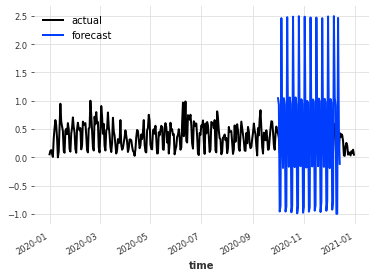

In [37]:
pred_ai = model_ai.predict(n=75, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:75],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
#fig1.savefig('forecast_75_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))


this is the error for the tweet_count: 66.75059846699527
MAPE = 66.75%


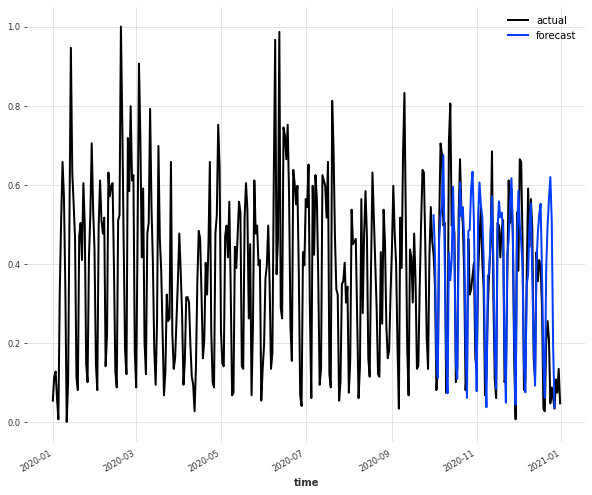

In [ ]:
pred_ai = model_ai.predict(n=88, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:88],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
fig1.savefig('forecast_88_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))

this is the error for the tweet_count: 36.80811405431139
MAPE = 36.81%


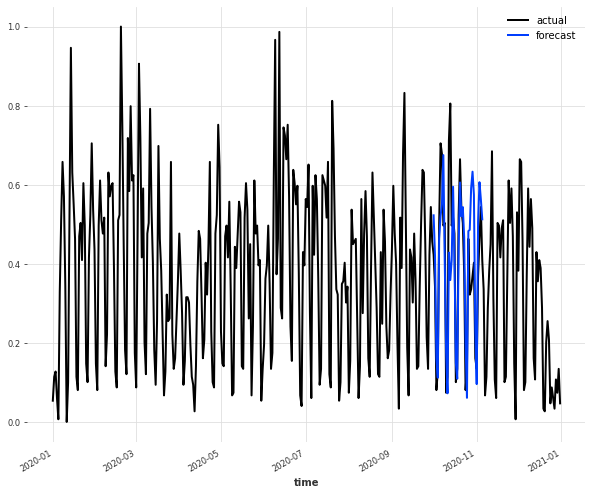

In [ ]:
pred_ai = model_ai.predict(n=36, series = train_tweet_count )
#pred_follower = model_ai_multiple.predict(n=36, series = train_follower )
error_tweet = mape(val_tweet_count[:36],pred_ai)
#error_follower = mape(val_follower[:36],pred_follower)
print("this is the error for the tweet_count:",error_tweet )
series_ai_count.plot(label='actual')
#val_retweet.plot(label= 'validation')
plt.rcParams['figure.figsize'] = [10, 8]
pred_ai.plot(label='forecast')
fig1 = plt.gcf()
plt.legend();
fig1.savefig('forecast_36_days.png')
print('MAPE = {:.2f}%'.format(mape(series_ai_count, pred_ai)))

In [ ]:
!pip install pyextremes

In [ ]:
from pyextremes import EVA, __version__
print("pyextremes", __version__)

pyextremes 2.0.0


In [ ]:
pred_ai_60 = model_ai.predict(n=60, series = train_tweet_count )
pred_ai_36 = model_ai.predict(n=36, series = train_tweet_count )
pred_ai_75 = model_ai.predict(n=75, series = train_tweet_count )

In [ ]:
pred_ai_36

<TimeSeries (DataArray) (time: 36, component: 1, sample: 1)>
array([[[0.52262162]],

       [[0.42097409]],

       [[0.15978732]],

       [[0.11200833]],

       [[0.46484952]],

       [[0.52032965]],

       [[0.55052553]],

       [[0.67488611]],

       [[0.40757884]],

       [[0.17716671]],

...

       [[0.48583842]],

       [[0.59118893]],

       [[0.63295929]],

       [[0.57436429]],

       [[0.23003742]],

       [[0.09570596]],

       [[0.50675528]],

       [[0.60638263]],

       [[0.56282209]],

       [[0.51252179]]])
Coordinates:
  * time       (time) datetime64[ns] 2020-10-01 2020-10-02 ... 2020-11-05
  * component  (component) object 'count'
Dimensions without coordinates: sample

In [ ]:
 series_pred_36= pred_ai_36.pd_series()
 series_pred_36

time
2020-10-01    0.522622
2020-10-02    0.420974
2020-10-03    0.159787
2020-10-04    0.112008
2020-10-05    0.464850
2020-10-06    0.520330
2020-10-07    0.550526
2020-10-08    0.674886
2020-10-09    0.407579
2020-10-10    0.177167
2020-10-11    0.072428
2020-10-12    0.428333
2020-10-13    0.358850
2020-10-14    0.409066
2020-10-15    0.594917
2020-10-16    0.419050
2020-10-17    0.148580
2020-10-18    0.109191
2020-10-19    0.443237
2020-10-20    0.605739
2020-10-21    0.520064
2020-10-22    0.543433
2020-10-23    0.466328
2020-10-24    0.199507
2020-10-25    0.060956
2020-10-26    0.482824
2020-10-27    0.485838
2020-10-28    0.591189
2020-10-29    0.632959
2020-10-30    0.574364
2020-10-31    0.230037
2020-11-01    0.095706
2020-11-02    0.506755
2020-11-03    0.606383
2020-11-04    0.562822
2020-11-05    0.512522
Freq: D, dtype: float64

In [ ]:
model = EVA(data= series_pred_36)

/usr/local/lib/python3.7/dist-packages/pyextremes/eva.py:84: FutureWarning:

Index.is_all_dates is deprecated, will be removed in a future version.  check index.inferred_type instead



In [ ]:
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                          None      Size:                                  36
Start:                       October 2020      End:                        November 2020
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                  3      Extraction method:                     BM
Type:                                high      Block size:              15 days 00:00:00
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='extreme values'>)

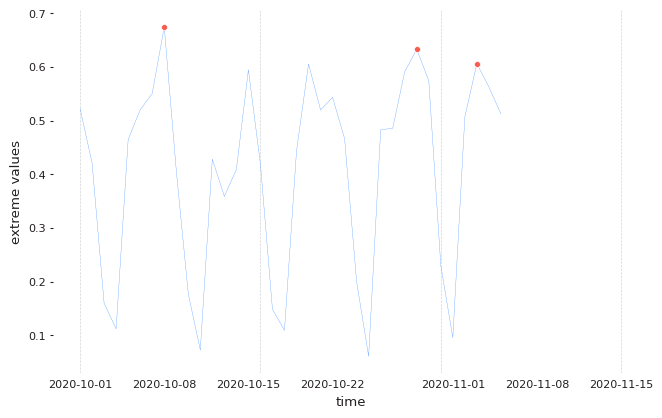

In [ ]:
model.plot_extremes()


In [ ]:
 series_pred_60= pred_ai_60.pd_series()
 series_pred_75 = pred_ai_75.pd_series()

In [ ]:
model_60 = EVA(data= series_pred_60)
model_75 = EVA(data= series_pred_75)

In [ ]:
model_60.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)
model_75.get_extremes(
    method="BM",
    extremes_type="high",
    block_size= pd.Timedelta("15 days"),
    errors="raise",
)

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='extreme values'>)

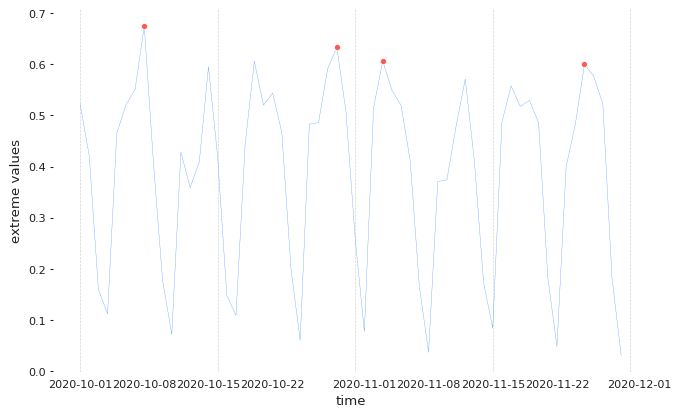

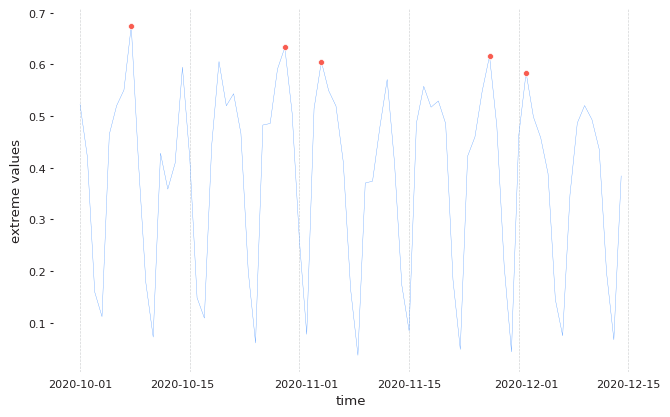

In [ ]:
model_60.plot_extremes()
model_75.plot_extremes()